In [249]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
from matplotlib import pyplot as plt # data visualization
import time
import re
import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


In [250]:
cdf = pd.read_csv("/kaggle/input/playground-series-s4e9/train.csv")
cdf_test = pd.read_csv("/kaggle/input/playground-series-s4e9/test.csv")

In [251]:
cdf

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900


# **1. Knowing the Data:~**

In [252]:
cdf.set_index('id', inplace=True)
cdf_test.set_index('id', inplace=True)

In [253]:
display(cdf.columns)
display(cdf_test.columns)

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'],
      dtype='object')

In [254]:
cdf.rename(columns={"ext_col":"ext_color", "int_col":"int_color", "milage":"mileage"}, inplace=True)
cdf_test.rename(columns={"ext_col":"ext_color", "int_col":"int_color", "milage":"mileage"}, inplace=True)

In [255]:
display(cdf.sample(5))
display(cdf_test.sample(5))

,brand,model,model_year,mileage,fuel_type,engine,transmission,ext_color,int_color,accident,clean_title,price
id,,,,,,,,,,,,
127723,Mercedes-Benz,AMG GT AMG GT S,2022,9728,Gasoline,503.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,Gray,Black,None reported,Yes,89000
180872,Mercedes-Benz,C-Class C 300 4MATIC,2020,46000,Gasoline,255.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Black,Black,At least 1 accident or damage reported,Yes,19425
151014,Subaru,Ascent Touring 7-Passenger,2014,82900,Gasoline,260.0HP 2.4L 4 Cylinder Engine Gasoline Fuel,CVT Transmission,Black,Black,None reported,Yes,19500
34129,Ford,Expedition Platinum,2019,65212,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Iconic Silver Metallic,Ebony,None reported,Yes,44775
64585,Land,Rover Range Rover 5.0L Supercharged Autobiogra...,2017,24650,Gasoline,510.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,79999


,brand,model,model_year,mileage,fuel_type,engine,transmission,ext_color,int_color,accident,clean_title
id,,,,,,,,,,,
241631,Toyota,Tundra SR5,2017,54500,Gasoline,381.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Gray,None reported,Yes
260611,Cadillac,Escalade ESV Platinum,2021,23292,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,Black,Black,None reported,Yes
293588,Acura,TLX V6 Tech,2023,4348,Gasoline,2.0L I4 16V GDI DOHC Turbo,10-Speed Automatic,Platinum White Pearl,Ebony,None reported,NaN
254863,GMC,Acadia SLT-1,2011,114528,Gasoline,288.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes
279619,Mercedes-Benz,GLC 300 Base 4MATIC,2017,46000,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,At least 1 accident or damage reported,Yes


In [256]:
print(f"Shape of training data: {cdf.shape}, \nShape of test data: {cdf_test.shape}")

Shape of training data: (188533, 12), 
Shape of test data: (125690, 11)


In [257]:
cdf.isnull().sum()

brand               0
model               0
model_year          0
mileage             0
fuel_type        5083
engine              0
transmission        0
ext_color           0
int_color           0
accident         2452
clean_title     21419
price               0
dtype: int64

In [258]:
cdf_test.isnull().sum()

brand               0
model               0
model_year          0
mileage             0
fuel_type        3383
engine              0
transmission        0
ext_color           0
int_color           0
accident         1632
clean_title     14239
dtype: int64

In [259]:
display(cdf[cdf.duplicated()])
display(cdf_test[cdf_test.duplicated()])

,brand,model,model_year,mileage,fuel_type,engine,transmission,ext_color,int_color,accident,clean_title,price
id,,,,,,,,,,,,


,brand,model,model_year,mileage,fuel_type,engine,transmission,ext_color,int_color,accident,clean_title
id,,,,,,,,,,,


### **SUMMARY from above //---**
* The train dataset has 13 columns, with "id" column set as index. So effectively 12. The test data has 11.
* There are **188533 rows in the train data.** While the **test dataset has 1.25lac rows.** 
* **No duplicates** in either of datset. **Both has three columns that has some null values.**
* "price" is the target column. Have **changed ext_col & int_col column names to ext_color & int_colour,** meaning Exterior & Interior Colour.

## **1.1. Details of the Numerical Columns:**

In [260]:
cdf.describe()

,model_year,mileage,price
count,188533.000000,188533.000000,1.885330e+05
mean,2015.829998,65705.295174,4.387802e+04
std,5.660967,49798.158076,7.881952e+04
min,1974.000000,100.000000,2.000000e+03
25%,2013.000000,24115.000000,1.700000e+04
50%,2017.000000,57785.000000,3.082500e+04
75%,2020.000000,95400.000000,4.990000e+04
max,2024.000000,405000.000000,2.954083e+06


Text(0.5, 1.0, 'Price of Cars')

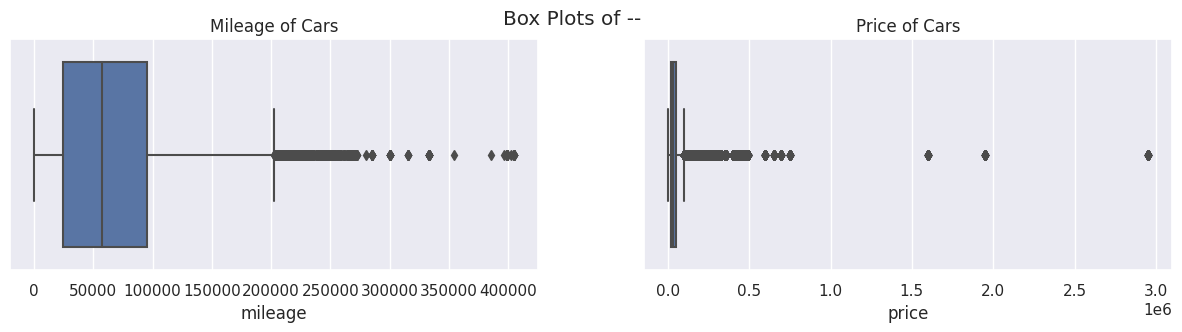

In [261]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharey=True)
fig.suptitle('Box Plots of --')

# mileage
sns.boxplot(ax=axes[0], x=cdf["mileage"])
axes[0].set_title("Mileage of Cars")

# price
sns.boxplot(ax=axes[1], x=cdf["price"])
axes[1].set_title("Price of Cars")

Text(0.5, 1.0, 'Price of Cars')

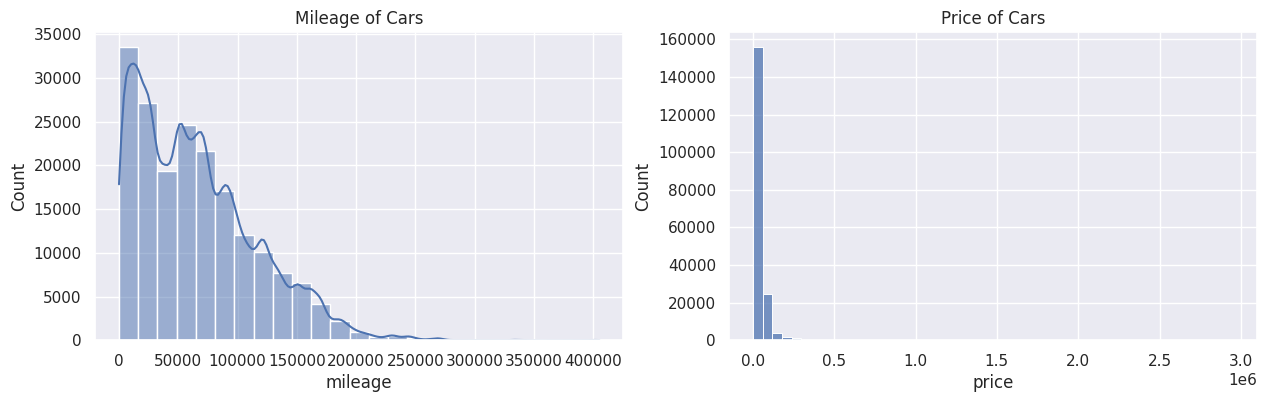

In [262]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# mileage
sns.histplot(x=cdf["mileage"],ax=axes[0],kde=True, bins=25)
axes[0].set_title("Mileage of Cars")

# price
sns.histplot(x=cdf["price"],ax=axes[1], bins=50)
axes[1].set_title("Price of Cars")

In [263]:
cdf.model_year.value_counts().head(5)

model_year
2021    18198
2018    16414
2020    15848
2022    15749
2019    15409
Name: count, dtype: int64

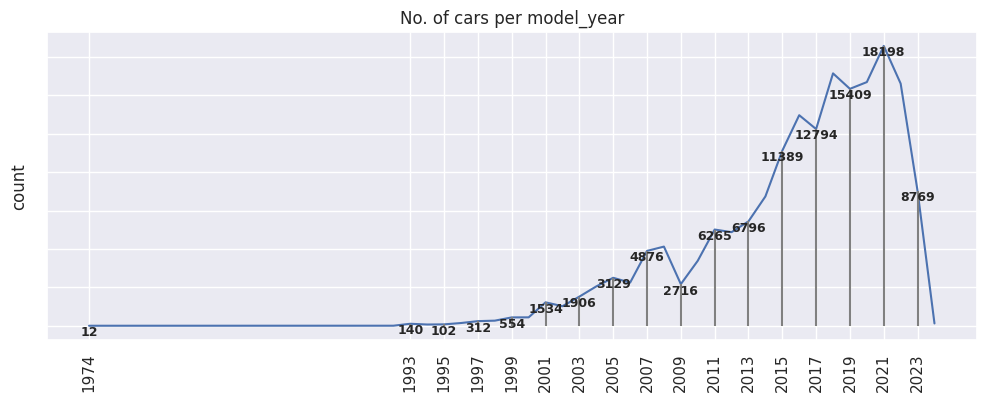

In [264]:
sns.set(rc={'figure.figsize':(12,4)})
yvc = cdf.model_year.value_counts().sort_index()
yr = sns.lineplot(x=list(yvc.index), y=yvc)
plt.xticks(list(yvc.index)[::2], rotation=90)

for i in range(0,len(yvc),2):
    yr.vlines(x=yvc.index[i],ymin=0,ymax=yvc.values[i],colors='grey',)
    yr.text(yvc.index[i],yvc.values[i], f"{yvc.values[i]}",ha='center',va="top", fontweight='bold', fontsize=9)

plt.title("No. of cars per model_year")
yr.set_yticklabels([])
plt.show()

## **1.2. Details of the Categorical Columns:**

In [265]:
cdf.describe(include="object")

,brand,model,fuel_type,engine,transmission,ext_color,int_color,accident,clean_title
count,188533,188533,183450,188533,188533,188533,188533,186081,167114
unique,57,1897,7,1117,52,319,156,2,1
top,Ford,F-150 XLT,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
freq,23088,2945,165940,3462,49904,48658,107674,144514,167114


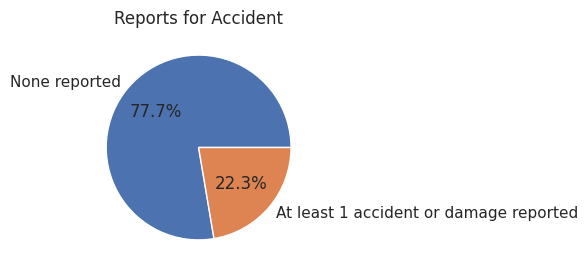

In [266]:
cdf.accident.value_counts().plot(kind="pie", title="Reports for Accident", ylabel="",
                                y=cdf.accident.value_counts(), figsize=(3,3),
                                autopct="%1.01f%%")
plt.show()

##### Let's make a little change to replace these long values "At least 1 accident or damage reported" & "None reported"

In [267]:
cdf.rename(columns={"accident":"accident_reported"}, inplace=True)
cdf_test.rename(columns={"accident":"accident_reported"}, inplace=True)
cdf.accident_reported = np.where(cdf.accident_reported=="None reported","No","Yes")
cdf_test.accident_reported = np.where(cdf_test.accident_reported=="None reported","No","Yes")

In [268]:
cdf.sample(3)

,brand,model,model_year,mileage,fuel_type,engine,transmission,ext_color,int_color,accident_reported,clean_title,price
id,,,,,,,,,,,,
176507,Land,Rover Range Rover P525 Westminster,2021,4665,Gasoline,5.0L V8 32V GDI DOHC Supercharged,Automatic,Santorini Black Metallic,Ebony,No,NaN,209995
65245,Hyundai,Palisade SEL,2023,38000,Gasoline,291.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Gray,Black,No,Yes,45000
116878,Acura,CX-30 Base,2006,131000,Gasoline,200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,Yes,Yes,11000


In [269]:
cdf.fuel_type.value_counts()

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [270]:
cdf.engine.value_counts()

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel           3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel           2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel           2841
2.0L I4 16V GDI DOHC Turbo                             2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel          2451
                                                       ... 
151.0HP 1.5L 4 Cylinder Engine Gas/Electric Hybrid        1
184.0HP 2.4L 4 Cylinder Engine Flex Fuel Capability       1
78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel               1
139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas       1
313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas       1
Name: count, Length: 1117, dtype: int64

In [271]:
cdf.transmission.value_counts(normalize=True)*100

transmission
A/T                                                   26.469637
8-Speed A/T                                           10.950338
Transmission w/Dual Shift Mode                        10.213066
6-Speed A/T                                            9.570738
6-Speed M/T                                            6.363873
7-Speed A/T                                            5.900293
Automatic                                              5.670625
8-Speed Automatic                                      4.471896
10-Speed A/T                                           4.266627
9-Speed A/T                                            2.050569
5-Speed A/T                                            1.706333
10-Speed Automatic                                     1.678221
6-Speed Automatic                                      1.484621
4-Speed A/T                                            1.350427
5-Speed M/T                                            1.277760
9-Speed Automatic          

In [272]:
display(cdf.ext_color.value_counts())
display(cdf.int_color.value_counts())

ext_color
Black                                 48658
White                                 43815
Gray                                  25293
Silver                                16995
Blue                                  14555
                                      ...  
GT SILVER                                 5
Blue Caelum                               5
Granite Crystal Metallic Clearcoat        5
BLUE                                      3
Mango Tango Pearlcoat                     2
Name: count, Length: 319, dtype: int64

int_color
Black           107674
Beige            24495
Gray             21204
Brown             5810
Red               5145
                 ...  
Nougat Brown         7
Classic Red          7
Cobalt Blue          6
WHITE                6
ORANGE               4
Name: count, Length: 156, dtype: int64

In [273]:
display(cdf.clean_title.value_counts())
cdf.clean_title.isnull().sum()

clean_title
Yes    167114
Name: count, dtype: int64

21419

### **SUMMARY from above //---**
* **Mileage column is right skewed** as it generally should be. **Price column has a lot of outliers,** probably fo the presence of a few supar cars.
* There are 12 cars of model year 1974. Most cars are of years between 2015 & 2022.
* **23% cars have at least one accident or damage being reported.**
* **`engine` & `transmission` columns have so many unique values.** Some column transformation can be done on those columns like creating a few smaller columns like Cylinder No, or Capacity etc.
* Color columns have many unique values as well, black being the most frequent for both Exterior and Interior color.

# **2. Data Cleaning and Processing:~**

In [274]:
cdf.isnull().sum()

brand                    0
model                    0
model_year               0
mileage                  0
fuel_type             5083
engine                   0
transmission             0
ext_color                0
int_color                0
accident_reported        0
clean_title          21419
price                    0
dtype: int64

## **2.1. Managing the `Fuel type` column** --

In [275]:
cdf.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [276]:
cdf_test.fuel_type.unique()

array(['Gasoline', 'Hybrid', 'Diesel', 'E85 Flex Fuel', nan,
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

### >> Data transformation ~

In [277]:
cdf['fuel_type'] = cdf['fuel_type'].replace(['–', 'not supported'], 'None')
cdf_test['fuel_type'] = cdf_test['fuel_type'].replace(['–', 'not supported'], 'None')

### >> Null Value Handling ~ 

In [278]:
cdf.fuel_type = cdf.fuel_type.fillna("Unknown")
cdf_test.fuel_type = cdf_test.fuel_type.fillna("Unknown")

## **2.2. Managing the `Transmission` column** --

In [279]:
cdf.transmission.unique()

array(['A/T', 'Transmission w/Dual Shift Mode', '7-Speed A/T',
       '8-Speed A/T', '10-Speed Automatic', '1-Speed A/T', '6-Speed A/T',
       '10-Speed A/T', '9-Speed A/T', '8-Speed Automatic',
       '9-Speed Automatic', '5-Speed A/T', 'Automatic',
       '7-Speed Automatic with Auto-Shift', 'CVT Transmission',
       '5-Speed M/T', 'M/T', '6-Speed M/T', '6-Speed Automatic',
       '4-Speed Automatic', '7-Speed M/T', '2-Speed A/T',
       '1-Speed Automatic', 'Automatic CVT', '4-Speed A/T',
       '6-Speed Manual', 'Transmission Overdrive Switch',
       '8-Speed Automatic with Auto-Shift', '7-Speed Manual',
       '7-Speed Automatic', '9-Speed Automatic with Auto-Shift',
       '6-Speed Automatic with Auto-Shift',
       '6-Speed Electronically Controlled Automatic with O', 'F', 'CVT-F',
       '8-Speed Manual', 'Manual', '–', '2', '6 Speed At/Mt',
       '5-Speed Automatic', '2-Speed Automatic', '8-SPEED A/T', '7-Speed',
       'Variable', 'Single-Speed Fixed Gear', '8-SPEED AT',


### >> Data Extraction ~
#### Transmission column have **more than 50 unique values** in it. That is because 2-3 different data are clubbed together in this column. So, those information like **no. of gears & transmission type are extracted from it.**

In [280]:
cdf.transmission = cdf.transmission.replace({"Single-Speed Fixed Gear":"1-Speed Fixed Gear"})
cdf_test.transmission = cdf_test.transmission.replace({"Single-Speed Fixed Gear":"1-Speed Fixed Gear"})

In [281]:
def extract_gear_and_txtype(transmission_info):
    pattern = re.search(r'(\d{1,2}[\s-]?speed?)?\s*(Automatic|Electronically Controlled Automatic|At\/Mt|A\/T|AT|M\/T|CVT|Manual|Variable|Transmission Overdrive|Fixed|DCT|Mt|Transmission w/Dual Shift Mode)?\s*',transmission_info,re.IGNORECASE)
    
    gear = pattern.group(1) if pattern.group(1) else None
    txtype = pattern.group(2) if pattern.group(2) else "Other"
    return gear, txtype

def load_gear_and_txtype(df):
    gear = []
    transmission_type = []
    for tx in df.transmission:
        ngear,txtype = extract_gear_and_txtype(tx)

        if ngear!=None:
            ngear = ngear.split("-")[0].split(" ")[0] #to tackle both 6-speed & 6 speed
            if ngear.lower()=="single":ngear=1
            else:ngear = int(ngear)

        if txtype!=None:
            if txtype=="At/Mt": txtype="AMT"
            elif txtype.lower() in ['a/t','at','transmission overdrive']: txtype = "Automatic"
            elif txtype.lower() in ['m/t','mt']: txtype = "Manual"
            elif txtype.lower()=="variable": txtype="CVT"
            elif txtype=="Transmission w/Dual Shift Mode": txtype="Dual Shift"

        gear.append(ngear)
        transmission_type.append(txtype)


    df["gears"] = gear
    df["transmission_type"] = transmission_type
    
    return df


In [282]:
cdf = load_gear_and_txtype(cdf)
cdf_test = load_gear_and_txtype(cdf_test)

In [283]:
display(cdf.gears.unique())
display(cdf_test.gears.unique())

array([nan,  7.,  8., 10.,  1.,  6.,  9.,  5.,  4.,  2.])

array([ 6.,  8., 10., nan,  7.,  5.,  9.,  1.,  4.,  2.])

In [284]:
display(cdf.transmission_type.unique())
display(cdf_test.transmission_type.unique())

array(['Automatic', 'Dual Shift', 'CVT', 'Manual',
       'Electronically Controlled Automatic', 'Other', 'AMT', 'Fixed',
       'DCT'], dtype=object)

array(['Automatic', 'Dual Shift', 'Manual', 'CVT', 'Other',
       'Electronically Controlled Automatic', 'DCT', 'Fixed', 'AMT'],
      dtype=object)

In [285]:
cdf.transmission_type.value_counts()

transmission_type
Automatic                              150422
Dual Shift                              19255
Manual                                  16395
CVT                                      2071
Other                                     305
Electronically Controlled Automatic        31
AMT                                        20
DCT                                        18
Fixed                                      16
Name: count, dtype: int64

## **2.3. Working with the `Engine` column** --

In [286]:
cdf.engine.nunique()

1117

In [287]:
cdf.engine.sample(5)

id
157376         241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel
58256     300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...
48095           375.0HP Electric Motor Electric Fuel System
179723                                 5.7L V8 16V MPFI OHV
94948         420.0HP 3.6L V6 Cylinder Engine Gasoline Fuel
Name: engine, dtype: object

### >> Data Extraction ~
#### Engine column too have a lot of unique values in it **(more than 50 unique values).** Again, this is because 3-4 different information are concatenated in this column. So, data related to **HorsePower, Capacity, & no. of Cylinders are extracted from it.**

In [288]:
def extract_engine_data(engine_info):
    pattern = re.search(r'(\d{1,4}.\d{1,2}HP)?\s?(\d{1,2}.\d{1,2}[L|\sLiter])?[A-Za-z\s]{0,}(\d{1,2})?\s?[Cylinder]{0,}',engine_info,re.IGNORECASE)
    
    hp = pattern.group(1) if pattern.group(1) else None
    capacity = pattern.group(2) if pattern.group(2) else None
    cylinders = pattern.group(3) if pattern.group(3) else None
    return hp, capacity, cylinders

def load_engine_data(df):
    horsepower, capacity, cylinders = [],[],[]
    i=0
    for engine in df.engine:
        hp, cap, cy = extract_engine_data(engine)
        if hp!=None:
            hp = float(hp.lower().split("hp")[0]) 

        if cap!=None:
            cap = float(cap.lower().split("l")[0])    

        if cy!=None:
            cy = float(cy.split(" ")[0])

        horsepower.append(hp)
        capacity.append(cap)
        cylinders.append(cy)


    df["horsepower"] = horsepower
    df["engine_capacity"] = capacity
    df["cylinders"] = cylinders
    
    return df

In [289]:
cdf = load_engine_data(cdf)
cdf_test = load_engine_data(cdf_test)

In [290]:
cdf[['engine','horsepower','engine_capacity','cylinders']].sample(5)

,engine,horsepower,engine_capacity,cylinders
id,,,,
157277,227.0HP 2.5L 5 Cylinder Engine Gasoline Fuel,227.0,2.5,5.0
47899,4.0 Liter Twin Turbo,NaN,4.0,NaN
97096,600.0HP 6.0L 12 Cylinder Engine Gasoline Fuel,600.0,6.0,12.0
187710,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,240.0,2.0,4.0
146745,3.6L V6 24V GDI DOHC,NaN,3.6,6.0


In [291]:
cdf_test[['engine','horsepower','engine_capacity','cylinders']].sample(5)

,engine,horsepower,engine_capacity,cylinders
id,,,,
277688,560.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,560.0,4.4,8.0
304910,3.0L V6 24V GDI DOHC Twin Turbo,NaN,3.0,6.0
247652,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,241.0,2.0,4.0
220401,200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,200.0,2.0,4.0
220778,302.0HP 3.5L V6 Cylinder Engine Flex Fuel Capa...,302.0,3.5,6.0


##### nan values in the newly added columns will be fixed later.

## **2.4. Fixing the `Exterior & Interior Color` columns** --

In [292]:
cdf.ext_color.nunique()

319

In [293]:
cdf.ext_color.value_counts(normalize=True).head(15)

ext_color
Black                     0.258087
White                     0.232400
Gray                      0.134157
Silver                    0.090143
Blue                      0.077201
Red                       0.052516
Green                     0.014310
Gold                      0.008847
Brown                     0.006163
Orange                    0.006041
Beige                     0.005766
Yellow                    0.005187
Bright White Clearcoat    0.004005
Diamond Black             0.003771
Agate Black Metallic      0.003389
Name: proportion, dtype: float64

In [294]:
cdf.int_color.value_counts(normalize=True).head(15)

int_color
Black           0.571115
Beige           0.129924
Gray            0.112468
Brown           0.030817
Red             0.027290
White           0.025157
–               0.024012
Jet Black       0.012719
Ebony           0.009722
Orange          0.004943
Blue            0.003941
Global Black    0.003331
Silver          0.002275
Nero Ade        0.002063
Gold            0.001947
Name: proportion, dtype: float64

### >> Data transformation ~
#### Colors columns are having many unique values as well because different color shades are present of a same parent color, e.g. both "Jet Black" & "Black" is present in the data. 
##### 
#### **The plan is to keep some of the common base colors. If a color has that base color in it, it will be changed to the base color, or else the color will be made uncommon,** i.e. "Jet Black" will be transformed to "Black" itself, but suppose we are not considering "pink" as our base color, so it will become 'uncommon'. 

In [295]:
base_colors = ['white','black','grey','gray','blue','red','yellow','silver','green','beige','gold','orange','brown','ebony','purple']

def find_base_color(text):
        for color in base_colors:
            if color in text:
                return color
        return "uncommon"  
    
def transform_color(df):    
    df.ext_color = df.ext_color.apply(lambda x: x.lower() if isinstance(x, str) else x)
    df.int_color = df.int_color.apply(lambda x: x.lower() if isinstance(x, str) else x)
    df.ext_color = df.ext_color.apply(find_base_color)
    df.int_color = df.int_color.apply(find_base_color)
    df.ext_color = df.ext_color.replace({"grey":"gray"})
    df.int_color = df.int_color.replace({"grey":"gray"})
    
    return df

cdf = transform_color(cdf)
cdf_test = transform_color(cdf_test)

In [296]:
cdf.ext_color.unique()

array(['yellow', 'silver', 'blue', 'black', 'white', 'gray', 'green',
       'purple', 'ebony', 'red', 'beige', 'gold', 'uncommon', 'orange',
       'brown'], dtype=object)

In [297]:
cdf.ext_color.value_counts(normalize=True)*100

ext_color
black       28.598176
white       25.430561
gray        14.360351
silver       9.976503
blue         8.400121
red          6.256199
uncommon     1.842648
green        1.563652
gold         0.884726
brown        0.628537
orange       0.608912
beige        0.581331
yellow       0.527229
purple       0.187766
ebony        0.153289
Name: proportion, dtype: float64

In [298]:
cdf.int_color.value_counts(normalize=True)*100

int_color
black       59.765134
beige       13.216254
gray        11.462715
uncommon     4.271401
brown        3.149581
red          2.920974
white        2.584693
ebony        1.110681
orange       0.513968
blue         0.441832
silver       0.227546
gold         0.194661
green        0.113508
yellow       0.027051
Name: proportion, dtype: float64

In [299]:
cdf.sample(2)

,brand,model,model_year,mileage,fuel_type,engine,transmission,ext_color,int_color,accident_reported,clean_title,price,gears,transmission_type,horsepower,engine_capacity,cylinders
id,,,,,,,,,,,,,,,,,
84608,INFINITI,Q50 Hybrid Premium,2023,49899,Gasoline,3.5 Liter SOHC,Automatic,black,uncommon,No,NaN,73897,NaN,Automatic,NaN,3.5,NaN
603,Ford,Transit-350 Base,2016,105760,Gasoline,310.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,blue,black,Yes,Yes,37899,NaN,Automatic,310.0,3.5,6.0


## **2.5. Dealing with the `clean title` columns** --

In [300]:
display(cdf.clean_title.value_counts())
print("----")
display(cdf_test.clean_title.value_counts())

clean_title
Yes    167114
Name: count, dtype: int64

----


clean_title
Yes    111451
Name: count, dtype: int64

In [301]:
cdf[['accident_reported','clean_title']].value_counts()

accident_reported  clean_title
No                 Yes            126687
Yes                Yes             40427
Name: count, dtype: int64

### >> Handling Null values ~
#### Logically clean title is dependent on accident/damage reports. If there are any Severe damage, its value is false. But cars with no reports of accident or minimal accidents... generally has a clean title. The above table show this.
#####  
#### So, to handle the Null values in this column, will take reference from the accident_reported column.

In [302]:
def fill_clean_title(row):
    if pd.isna(row['clean_title']):
        if row['accident_reported'] == 'No':
            return "Yes"
        elif row['accident_reported'] == 'Yes':
            return "No"
    return row['clean_title']

# Apply the function to each row
cdf.clean_title = cdf.apply(fill_clean_title, axis=1)
cdf_test.clean_title = cdf_test.apply(fill_clean_title, axis=1)

In [303]:
cdf[['accident_reported','clean_title']].value_counts()

accident_reported  clean_title
No                 Yes            144514
Yes                Yes             40427
                   No               3592
Name: count, dtype: int64

In [304]:
cdf_test[['accident_reported','clean_title']].value_counts()

accident_reported  clean_title
No                 Yes            96263
Yes                Yes            27023
                   No              2404
Name: count, dtype: int64

## **2.6. Managing the `brand & Model` columns** --

In [305]:
cdf.brand.unique()

array(['MINI', 'Lincoln', 'Chevrolet', 'Genesis', 'Mercedes-Benz', 'Audi',
       'Ford', 'BMW', 'Tesla', 'Cadillac', 'Land', 'GMC', 'Toyota',
       'Hyundai', 'Volvo', 'Volkswagen', 'Buick', 'Rivian', 'RAM',
       'Hummer', 'Alfa', 'INFINITI', 'Jeep', 'Porsche', 'McLaren',
       'Honda', 'Lexus', 'Dodge', 'Nissan', 'Jaguar', 'Acura', 'Kia',
       'Mitsubishi', 'Rolls-Royce', 'Maserati', 'Pontiac', 'Saturn',
       'Bentley', 'Mazda', 'Subaru', 'Ferrari', 'Aston', 'Lamborghini',
       'Chrysler', 'Lucid', 'Lotus', 'Scion', 'smart', 'Karma',
       'Plymouth', 'Suzuki', 'FIAT', 'Saab', 'Bugatti', 'Mercury',
       'Polestar', 'Maybach'], dtype=object)

In [306]:
cdf.model.nunique()

1897

In [307]:
cdf[['brand','model']].value_counts().head(50)

brand          model                                   
Ford           F-150 XLT                                   2934
BMW            M3 Base                                     2195
Chevrolet      Camaro 2SS                                  1699
BMW            M4 Base                                     1608
Ford           Mustang GT Premium                          1515
               F-150 Lariat                                1404
Mercedes-Benz  E-Class E 350 4MATIC                        1352
RAM            1500 Laramie                                1243
Porsche        911 Carrera S                               1211
Chevrolet      Corvette Base                               1177
Mercedes-Benz  E-Class E 350                               1146
Lexus          GX 460 Base                                 1120
Porsche        911 Carrera                                 1101
Ford           Explorer XLT                                1083
Chevrolet      Corvette Stingray w/2LT          

In [308]:
cdf[["brand","price"]].groupby('brand').median(['price']).sort_values("price",ascending=False).head(10)

,price
brand,
Bugatti,220000.0
Lamborghini,102000.0
McLaren,87500.0
Rivian,78000.0
Rolls-Royce,77500.0
Ferrari,75500.0
Bentley,73600.0
Aston,67650.0
Lucid,56000.0


### >> Data transformation ~
#### Have classified the cars into 5 classes based on the brand's price, performance and utilizations. This is feature reduction as well as to maintain the brand-value as is.

In [309]:
# Car brand categories
categories = {
    'Exotic_car': [
        'Bugatti', 'Ferrari', 'Lamborghini', 'McLaren', 'Rolls-Royce',
        'Bentley', 'Aston', 'Koenigsegg', 'Pagani'
    ],
    'Super_car': ['Porsche', 'Maserati', 'Lotus'],
    'Luxury_car': [
        'Mercedes-Benz', 'Audi', 'BMW', 'Genesis', 'Cadillac', 'Lincoln',
        'Land', 'Jaguar', 'Tesla', 'Lexus', 'INFINITI', 'Acura',
        'Polestar', 'Maybach'
    ],
    'Premium_car': [
        'Volvo', 'Volkswagen', 'Buick', 'Rivian', 'RAM', 'Alfa', 'Jeep'
    ],
    'Standard_car': [
        'MINI', 'Chevrolet', 'Ford', 'GMC', 'Toyota', 'Hyundai', 'Kia', 
        'Mitsubishi', 'Honda', 'Nissan', 'Mazda', 'Subaru', 'Chrysler', 'Lucid', 
        'Scion', 'smart', 'Karma', 'Plymouth', 'Suzuki', 'FIAT', 'Saab', 
        'Pontiac', 'Saturn', 'Dodge', 'Hummer', 'Mercury'
    ]
}

# Function to classify brands
def classify_brand(brand):
    for category, brands in categories.items():
        if brand in brands:
            return category
    return "Other"

# Apply classification to the DataFrame
cdf['car_category'] = cdf.brand.apply(classify_brand)
cdf_test['car_category'] = cdf_test.brand.apply(classify_brand)


In [311]:
cdf_test.car_category.value_counts()

car_category
Luxury_car      55840
Standard_car    49306
Premium_car     10471
Super_car        7791
Exotic_car       2282
Name: count, dtype: int64

In [312]:
cdf.sample(5)

,brand,model,model_year,mileage,fuel_type,engine,transmission,ext_color,int_color,accident_reported,clean_title,price,gears,transmission_type,horsepower,engine_capacity,cylinders,car_category
id,,,,,,,,,,,,,,,,,,
133836,Maserati,Ghibli S Q4 GranSport,2017,49750,Gasoline,424.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,gray,black,No,Yes,21000,8.0,Automatic,424.0,3.0,6.0,Super_car
170090,Chevrolet,Camaro 1LT,2009,112000,Gasoline,300.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,silver,black,No,Yes,10400,6.0,Automatic,300.0,3.6,6.0,Standard_car
112312,Ford,Bronco Outer Banks Advanced,2023,1500,Gasoline,275.0HP 2.3L 4 Cylinder Engine Gasoline Fuel,10-Speed A/T,gray,gray,No,Yes,51900,10.0,Automatic,275.0,2.3,4.0,Standard_car
93221,Mercedes-Benz,AMG GLE 43 Coupe 4MATIC,2018,52694,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,9-Speed A/T,blue,black,Yes,Yes,41000,9.0,Automatic,385.0,3.0,6.0,Luxury_car
72746,Toyota,4Runner SR5,2020,32000,Gasoline,270.0HP 4.0L V6 Cylinder Engine Gasoline Fuel,A/T,black,beige,No,Yes,34700,NaN,Automatic,270.0,4.0,6.0,Standard_car


## **2.7. Handling Null values in NEW Numerical columns** --

#### The plan is to fill the null values with the mode of corresponding columns of those rows that have the same brand and model name. If that also is null, null is filled with mode of same brand name only. 

In [313]:
cdf.isnull().sum()

brand                    0
model                    0
model_year               0
mileage                  0
fuel_type                0
engine                   0
transmission             0
ext_color                0
int_color                0
accident_reported        0
clean_title              0
price                    0
gears                84361
transmission_type        0
horsepower           33259
engine_capacity       6766
cylinders            14218
car_category             0
dtype: int64

In [314]:
# def fill_gears_na(df, row):
#     same_brand = row['brand']
#     same_model = row['model']

#     try:
#         same_gears = df[(df.brand==same_brand) & (df.model==same_model)].gears.mode()[0]
#         return same_gears
#     except:
#         return df[df.brand==same_brand].gears.mode()[0]       


# for i in range(len(cdf)):
#     if pd.isna(cdf.loc[i,'gears']):
#         cdf.loc[i,'gears'] = fill_gears_na(cdf, cdf.loc[i,:])


## THIS TAKES LOT OF TIME TO RUN

In [315]:
cdf

,brand,model,model_year,mileage,fuel_type,engine,transmission,ext_color,int_color,accident_reported,clean_title,price,gears,transmission_type,horsepower,engine_capacity,cylinders,car_category
id,,,,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,yellow,gray,No,Yes,4200,NaN,Automatic,172.0,1.6,4.0,Standard_car
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,silver,beige,Yes,Yes,4999,NaN,Automatic,252.0,3.9,8.0,Luxury_car
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,blue,gray,No,Yes,13900,NaN,Automatic,320.0,5.3,8.0,Standard_car
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,black,black,No,Yes,45000,NaN,Dual Shift,420.0,5.0,8.0,Luxury_car
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,black,beige,No,Yes,97500,7.0,Automatic,208.0,2.0,4.0,Luxury_car
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,white,beige,No,Yes,27500,NaN,Dual Shift,420.0,6.2,8.0,Luxury_car
188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,white,black,Yes,Yes,30000,8.0,Automatic,385.0,3.0,6.0,Luxury_car
188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,white,black,No,Yes,86900,7.0,Automatic,469.0,4.0,8.0,Luxury_car


In [316]:
def fill_na_with_same_brand_model_mode(df, grouping_cols, target_cols):
    
    # Mode Calculator
    def calculate_mode(series):
        mode = series.mode()
        return mode.iloc[0] if not mode.empty else np.nan
    
    # NA filler function
    def impute_na(row):
        if pd.notna(row[col]):
            return row[col]
        if pd.notna(row['brand_model_mode']):
            return row['brand_model_mode']
        if pd.notna(row['brand_mode']):
            return row['brand_mode']

        return row[col]
    
    #-------------
    for col in target_cols:
        # find mode of same brand & model
        brand_model_mode = df.groupby(grouping_cols)[col].apply(calculate_mode).rename("brand_model_mode")
        
        # find mode of same brand
        brand_mode = df.groupby(grouping_cols[0])[col].apply(calculate_mode).rename("brand_mode")
        
        #merging the series to have corresponding mode for each brand & band_model combo in each rows
        df = df.merge(brand_model_mode, on=grouping_cols, how='left')
        df = df.merge(brand_mode, on=grouping_cols[0], how='left')
        
        #applying na_filler function
        df[col] = df.apply(impute_na, axis=1)
        
        #deleting newly added cols
        df.drop(columns=['brand_model_mode','brand_mode'],inplace=True)
    
    return df
 

In [317]:
cdf = fill_na_with_same_brand_model_mode(cdf, ['brand','model'], ['gears','horsepower','engine_capacity','cylinders'])
cdf_test = fill_na_with_same_brand_model_mode(cdf_test, ['brand','model'], ['gears','horsepower','engine_capacity','cylinders'])

In [318]:
cdf.isnull().sum()

brand                0
model                0
model_year           0
mileage              0
fuel_type            0
engine               0
transmission         0
ext_color            0
int_color            0
accident_reported    0
clean_title          0
price                0
gears                0
transmission_type    0
horsepower           7
engine_capacity      0
cylinders            0
car_category         0
dtype: int64

In [319]:
# 10 rows had null in them. All for same model: Bugatti--Veyron 16.4 Grand Sport: 1200 HP checked from google and filled.

cdf.horsepower = cdf.horsepower.fillna(1200)
cdf_test.horsepower = cdf_test.horsepower.fillna(1200)

## **2.8. New Column in place of `Model year`** --

#### year as in 2002, 2020, 2023 doesn't have any numerical info in it. It is more like a categorical column only. So, a new column `car_age` is created to have that longivity feel for the cars.

In [320]:
cdf['car_age'] = 2024-cdf.model_year
cdf_test['car_age'] = 2024-cdf_test.model_year

In [321]:
cdf.sample(5)

,brand,model,model_year,mileage,fuel_type,engine,transmission,ext_color,int_color,accident_reported,clean_title,price,gears,transmission_type,horsepower,engine_capacity,cylinders,car_category,car_age
11114,Ford,F-250 XL,2015,67303,E85 Flex Fuel,385.0HP 6.2L 8 Cylinder Engine Flex Fuel Capab...,A/T,gray,gray,No,Yes,30000,6.0,Automatic,385.0,6.2,8.0,Standard_car,9
176722,Lexus,RX 350 Base,2011,120000,Gasoline,270.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,black,black,No,Yes,6000,6.0,Automatic,270.0,3.5,6.0,Luxury_car,13
71795,Volvo,XC90 T6 Momentum,2018,66500,Gasoline,316.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,8-Speed A/T,silver,black,Yes,Yes,34000,8.0,Automatic,316.0,2.0,4.0,Premium_car,6
119646,Hyundai,Genesis Coupe 3.8 Track,2010,75000,Gasoline,306.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,black,black,Yes,Yes,11995,6.0,Automatic,306.0,3.8,6.0,Standard_car,14
67568,Chevrolet,Suburban LT,2015,67289,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,black,black,No,Yes,29500,6.0,Automatic,355.0,5.3,8.0,Standard_car,9


## **2.9. Dropping unwanted columns** --

#### As a result of the above part, EDA-2 is done. We have handled all Null values, processed & transformed columns to modify the existing columns... as well as to create a few new ones. 
* Let's remove the redundant columns now. &
* modify the dataset view.

In [322]:
cdf.drop(columns=['brand','model','model_year','engine','transmission'], inplace=True)
cdf_test.drop(columns=['brand','model','model_year','engine','transmission'], inplace=True)

In [323]:
cdf = cdf[['car_category', 'fuel_type', 'transmission_type', 'int_color', 'ext_color', #cat_cols
           'accident_reported', 'clean_title', #binary_cols
           'car_age', 'mileage', 'gears', 'horsepower', 'engine_capacity', 'cylinders', 'price']] #num_cols

cdf_test = cdf_test[['car_category', 'fuel_type', 'transmission_type', 'int_color', 'ext_color', #cat_cols
                     'accident_reported', 'clean_title', #binary_cols
                     'car_age', 'mileage', 'gears', 'horsepower', 'engine_capacity', 'cylinders']] #num_cols

In [324]:
cdf

,car_category,fuel_type,transmission_type,int_color,ext_color,accident_reported,clean_title,car_age,mileage,gears,horsepower,engine_capacity,cylinders,price
0,Standard_car,Gasoline,Automatic,gray,yellow,No,Yes,17,213000,6.0,172.0,1.6,4.0,4200
1,Luxury_car,Gasoline,Automatic,beige,silver,Yes,Yes,22,143250,5.0,252.0,3.9,8.0,4999
2,Standard_car,E85 Flex Fuel,Automatic,gray,blue,No,Yes,22,136731,6.0,320.0,5.3,8.0,13900
3,Luxury_car,Gasoline,Dual Shift,black,black,No,Yes,7,19500,8.0,420.0,5.0,8.0,45000
4,Luxury_car,Gasoline,Automatic,beige,black,No,Yes,3,7388,7.0,208.0,2.0,4.0,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,Luxury_car,Gasoline,Dual Shift,beige,white,No,Yes,7,49000,10.0,420.0,6.2,8.0,27500
188529,Luxury_car,Gasoline,Automatic,black,white,Yes,Yes,6,28600,8.0,385.0,3.0,6.0,30000
188530,Luxury_car,Gasoline,Automatic,black,white,No,Yes,3,13650,7.0,469.0,4.0,8.0,86900
188531,Luxury_car,Gasoline,Automatic,black,gray,No,Yes,2,13895,1.0,333.0,3.0,6.0,84900


In [325]:
cdf_test

,car_category,fuel_type,transmission_type,int_color,ext_color,accident_reported,clean_title,car_age,mileage,gears,horsepower,engine_capacity,cylinders
0,Luxury_car,Gasoline,Automatic,beige,white,No,Yes,9,98000,6.0,240.0,2.0,4.0
1,Luxury_car,Hybrid,Automatic,black,silver,No,Yes,4,9142,8.0,395.0,3.0,6.0
2,Standard_car,Gasoline,Automatic,ebony,white,No,Yes,2,28121,10.0,440.0,3.5,6.0
3,Luxury_car,Gasoline,Automatic,black,yellow,No,Yes,8,61258,7.0,252.0,2.0,4.0
4,Luxury_car,Gasoline,Automatic,black,gray,No,Yes,6,59000,8.0,252.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125685,Luxury_car,Gasoline,Automatic,black,black,No,Yes,10,83315,7.0,362.0,3.0,6.0
125686,Luxury_car,Gasoline,Automatic,black,white,No,Yes,5,29336,8.0,329.0,3.0,6.0
125687,Luxury_car,Gasoline,Automatic,black,black,No,Yes,12,77634,8.0,333.0,3.0,6.0
125688,Luxury_car,Gasoline,Automatic,black,black,No,Yes,12,112000,8.0,333.0,3.0,6.0
